## Вводные данные

На вход получаем файлы по месяцам, которые сложены в категории /data/ проекта

**важным требованием является отсутствие дубликатов дат в исходных выгрузках**

Для начала импортируем все необзходимые библиотеки

In [12]:
import os
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                       
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 12)    

Соберём все файлы в одну большую транспонированную табличку

In [13]:
total_df = pd.DataFrame()
for i in os.listdir('./data/'):
    df = pd.read_excel('./data/'+i).T.drop(0, axis=1).reset_index()
    df['tf'] = df['index'].str.contains('201')
    df = df[df['tf'] == True].drop('tf', axis=1)
    total_df = pd.concat([total_df,df])
total_df = total_df.drop([2,3], axis = 1).fillna(0)
total_df['index'] = pd.to_datetime(total_df['index'], format = "%d.%m.%Y")
total_df = total_df.sort_values(by = 'index').set_index('index')
total_df.columns = ['visits']
total_df.head(2)

,visits
index,
2017-09-25,21
2017-09-25,21


Посмотрим на наши данные

In [14]:
total_df.describe().T

,count,mean,std,min,25%,50%,75%,max
visits,405.0,26.68642,7.396342,0.0,22.0,26.0,31.0,50.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c10d2c470>]], dtype=object)

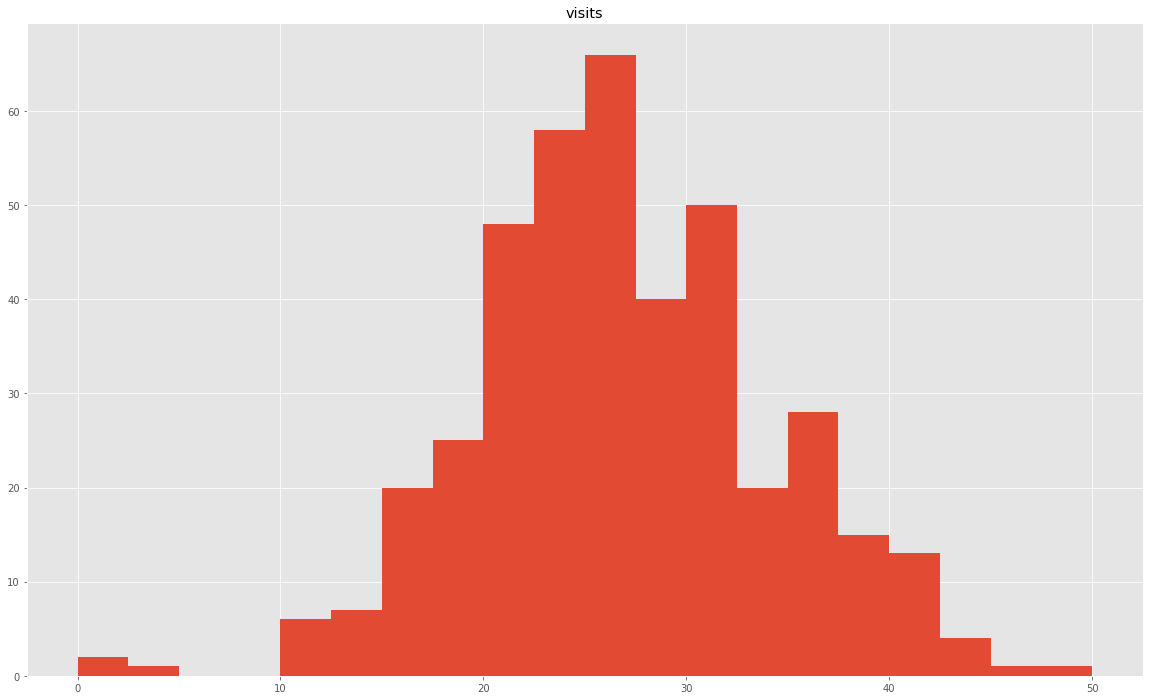

In [15]:
total_df.hist(bins = 20)

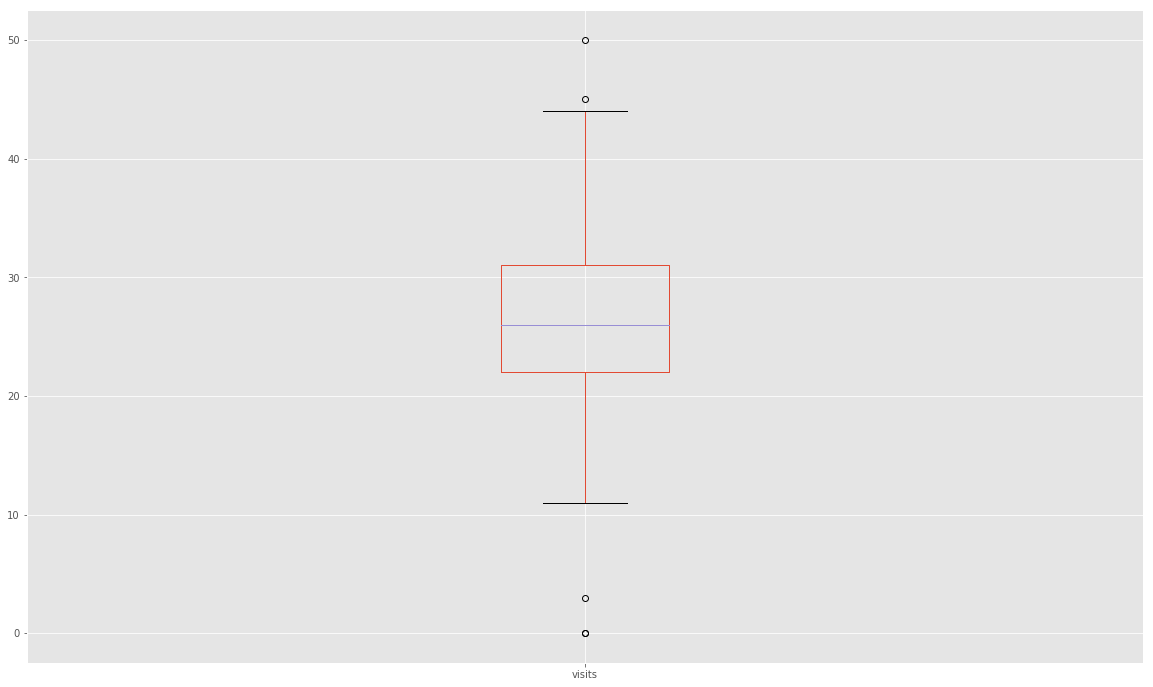

In [16]:
total_df.boxplot()

(array([   2.,    2.,    4.,    7.,    3.,   20.,   21.,   46.,  110.,  190.]),
 array([-0.28285923, -0.24705586, -0.21125248, -0.17544911, -0.13964573,
        -0.10384236, -0.06803898, -0.03223561,  0.00356777,  0.03937114,
         0.07517452]),
 <a list of 10 Patch objects>)

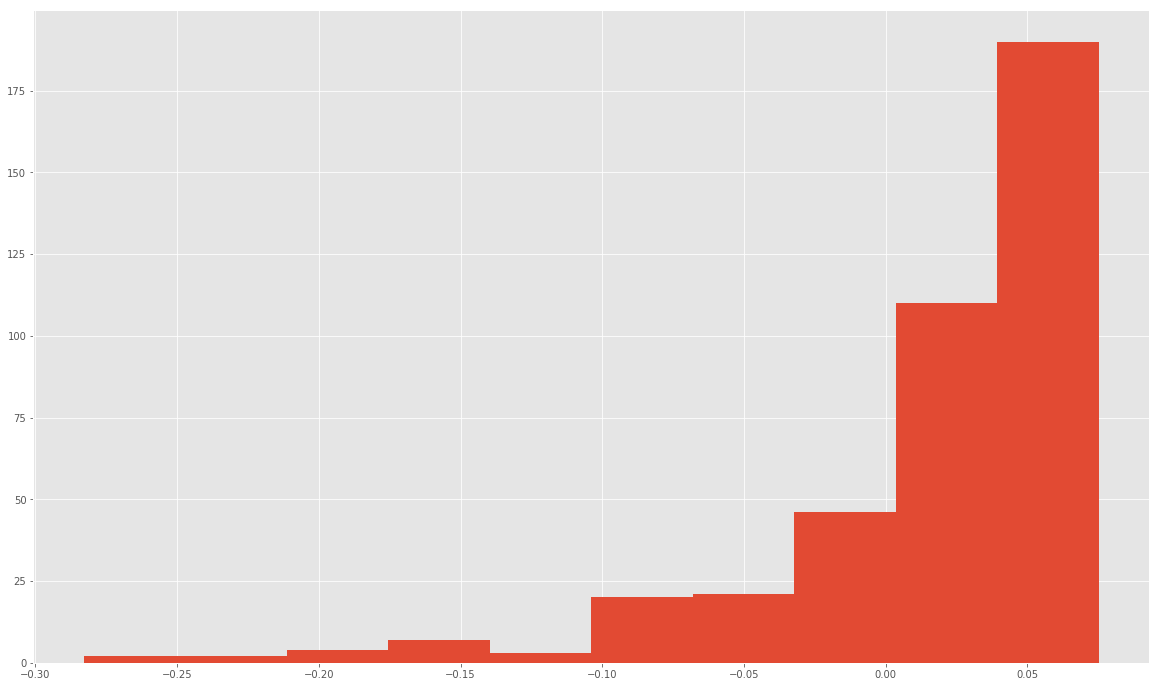

In [17]:
from sklearn.ensemble import IsolationForest

X = total_df.values
model = IsolationForest(n_estimators=100, 
                        max_samples=256, 
                        n_jobs=-1, 
                        random_state=123)

model.fit(X)

score = model.decision_function(X)

plt.hist(score)

In [18]:
model.threshold_

/Users/aleksandrpolakov/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


-0.052537119660914011

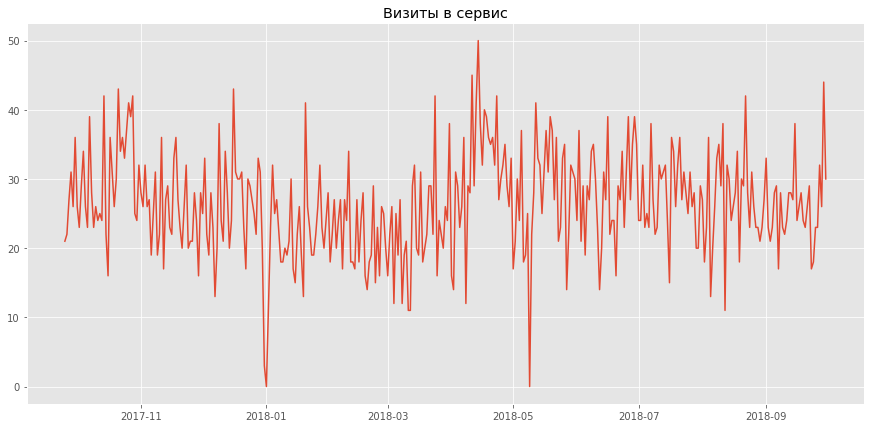

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(total_df.visits)
plt.title('Визиты в сервис')
plt.grid(True)
plt.show()

## Rolling window estimations

исследуем получившийся ряд скользящим средним


In [20]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [21]:
moving_average(total_df, 6)

29.666666666666668

In [22]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживание по 10 дням

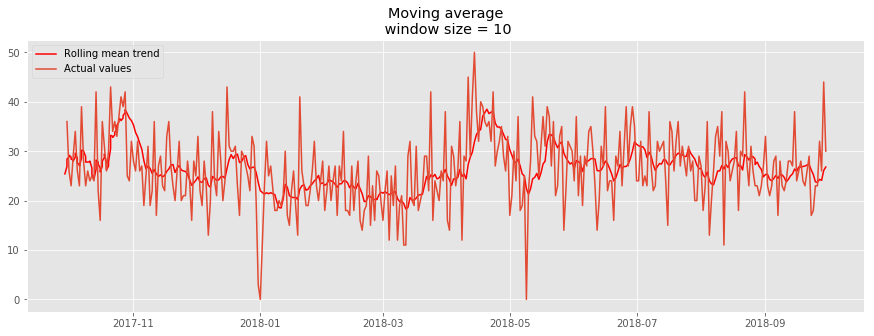

In [23]:
plotMovingAverage(total_df, 10)

Сглаживание по 30 дням

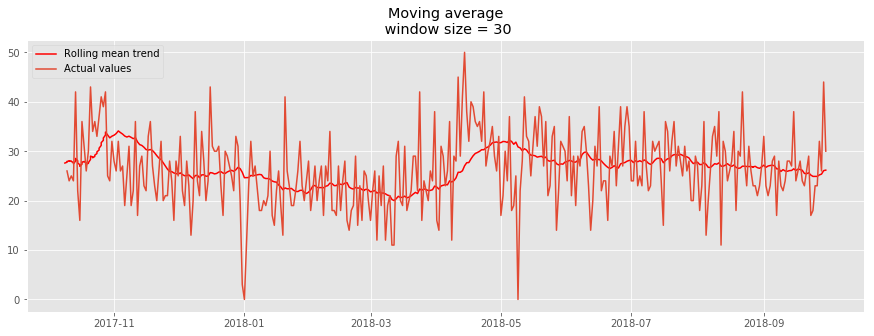

In [24]:
plotMovingAverage(total_df, 30)

С доверительными интервалами

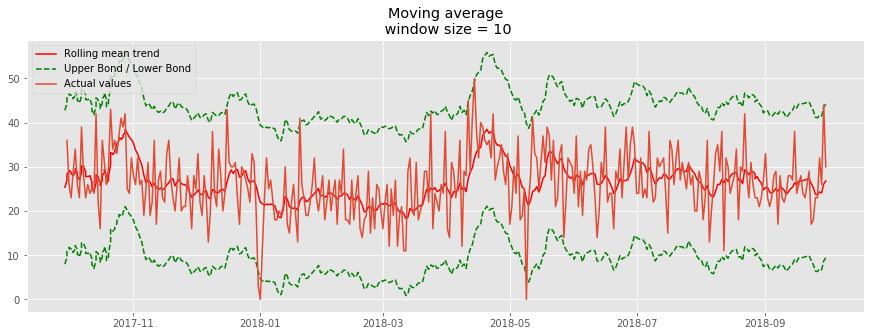

In [25]:
plotMovingAverage(total_df, 10, plot_intervals=True)

Пробуем засечь аномалии

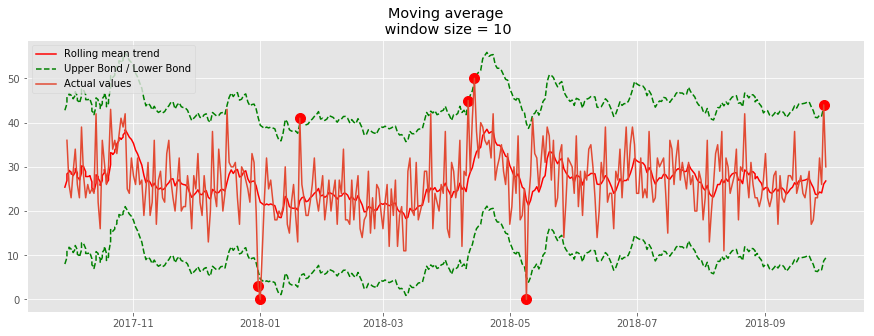

In [26]:
plotMovingAverage(total_df, 10, plot_intervals=True, plot_anomalies=True)

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [27]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # первое значение такое же, как в исходном ряде
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [28]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

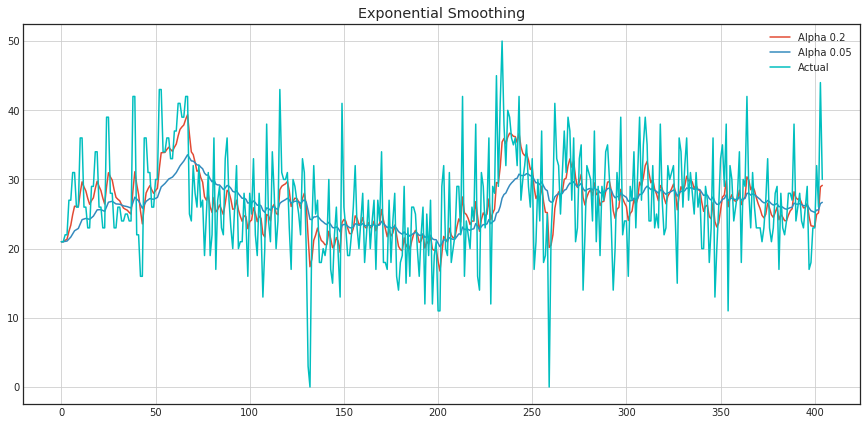

In [29]:
plotExponentialSmoothing(total_df.visits, [0.2, 0.05])

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [30]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # первое значение такое же, как в исходном ряде
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

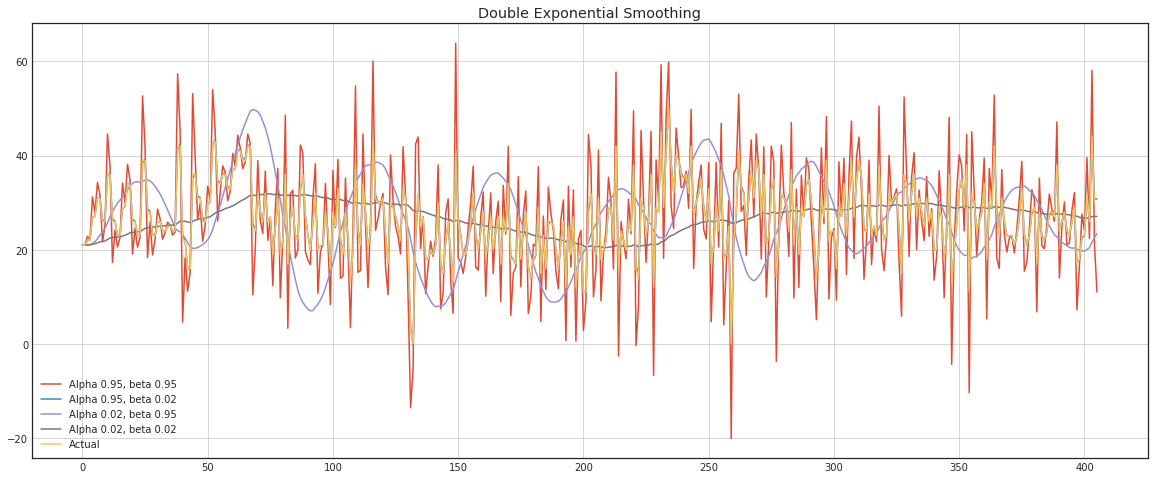

In [31]:
plotDoubleExponentialSmoothing(total_df.visits, alphas=[0.95, 0.02], betas=[0.95, 0.02])

Теперь у нас появилась возможность настраивать уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. 

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [32]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [33]:
%%time
data = total_df.visits[:250] # отложим 50 наблюдений для тестирования
slen = 30 # 30 дневная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0310500729028 0.0 0.0751898166032
CPU times: user 1.2 s, sys: 8.7 ms, total: 1.2 s
Wall time: 1.2 s


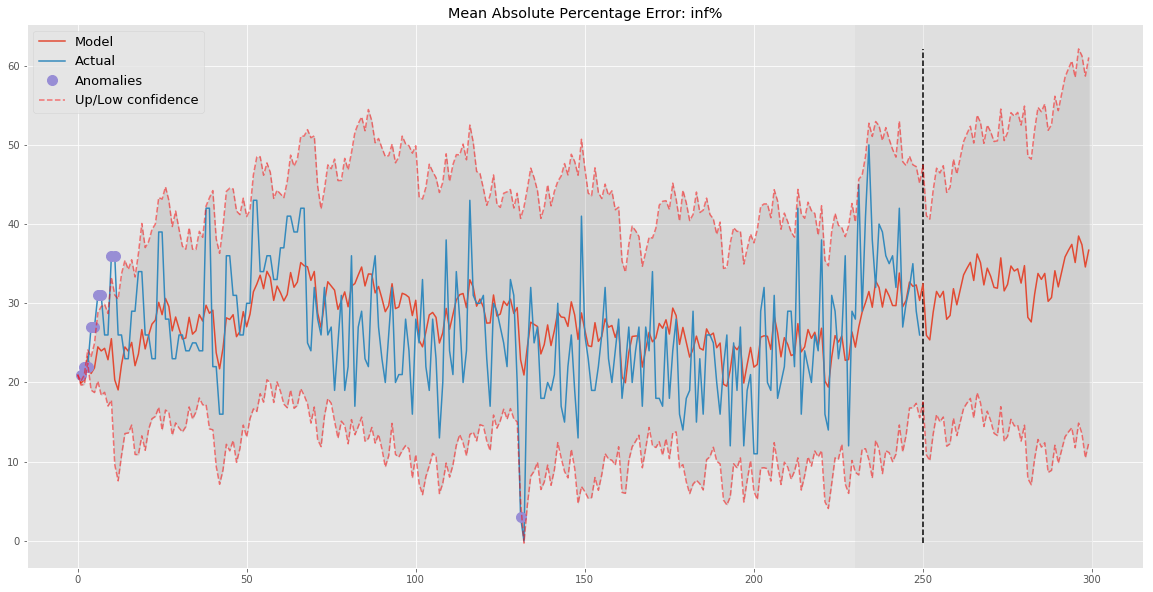

In [34]:
plotHoltWinters( total_df.visits[:250], plot_intervals=True, plot_anomalies=True)

## попробуем ML

In [72]:
data = pd.DataFrame(total_df.visits.copy())
data.columns = ["y"]

In [73]:
for i in range(3, 31):
    data["lag_{}".format(i)] = data.y.shift(i)

In [74]:
# посмотрим, как теперь выглядит датасет
data.tail(7)

,y,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
index,,,,,,,,,,,,,,,,,,,,,
2018-09-24,18,26.0,23.0,24.0,28.0,26.0,24.0,38.0,27.0,28.0,...,21.0,23.0,33.0,27.0,23.0,21.0,23.0,23.0,23.0,26.0
2018-09-25,23,29.0,26.0,23.0,24.0,28.0,26.0,24.0,38.0,27.0,...,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0,23.0,23.0
2018-09-26,23,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,38.0,...,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0,23.0
2018-09-27,32,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,...,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0
2018-09-28,26,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,...,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0
2018-09-29,44,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,...,28.0,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0
2018-09-30,30,32.0,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,...,23.0,28.0,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0


In [75]:
data.shape

(405, 29)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [77]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [78]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [79]:
X_train.shape, X_test.shape

((262, 28), (113, 28))

In [80]:
# учим регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

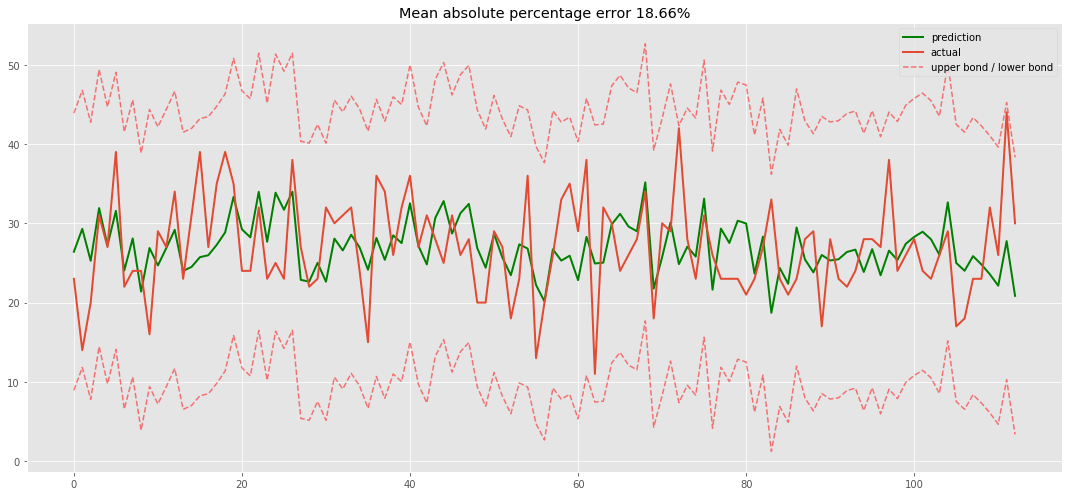

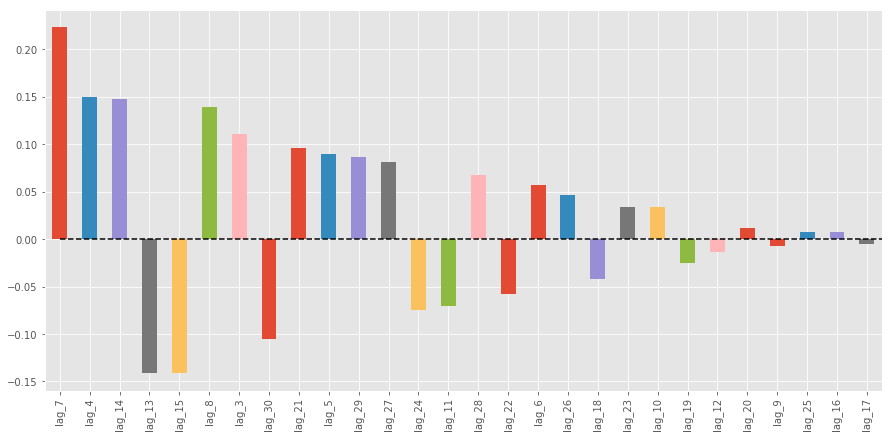

In [82]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [83]:
data.tail()

,y,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
index,,,,,,,,,,,,,,,,,,,,,
2018-09-26,23,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,38.0,...,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0,23.0
2018-09-27,32,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,...,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0
2018-09-28,26,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,...,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0
2018-09-29,44,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,...,28.0,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0
2018-09-30,30,32.0,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,...,23.0,28.0,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0


In [84]:
data.index = pd.to_datetime(data.index)
#data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,weekday,is_weekend
index,,,,,,,,,,,,,,,,,,,,,
2018-09-26,23,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,38.0,...,21.0,23.0,33.0,27.0,23.0,21.0,23.0,23.0,2,0
2018-09-27,32,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,24.0,...,23.0,21.0,23.0,33.0,27.0,23.0,21.0,23.0,3,0
2018-09-28,26,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,26.0,...,28.0,23.0,21.0,23.0,33.0,27.0,23.0,21.0,4,0
2018-09-29,44,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,28.0,...,29.0,28.0,23.0,21.0,23.0,33.0,27.0,23.0,5,1
2018-09-30,30,32.0,23.0,23.0,18.0,17.0,29.0,26.0,23.0,24.0,...,17.0,29.0,28.0,23.0,21.0,23.0,33.0,27.0,6,1


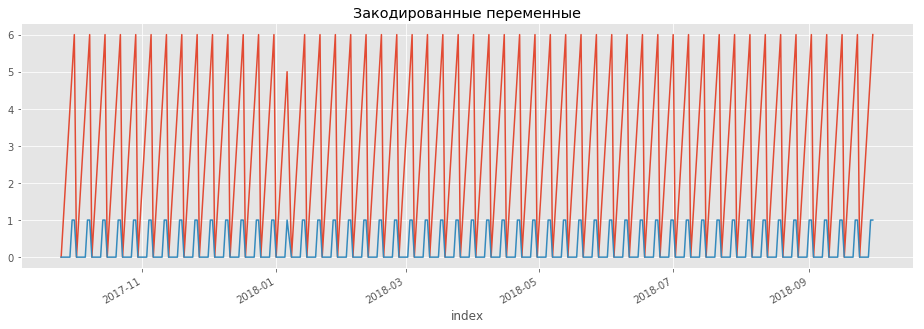

In [86]:
plt.figure(figsize=(16, 5))
plt.title("Закодированные переменные")
#data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

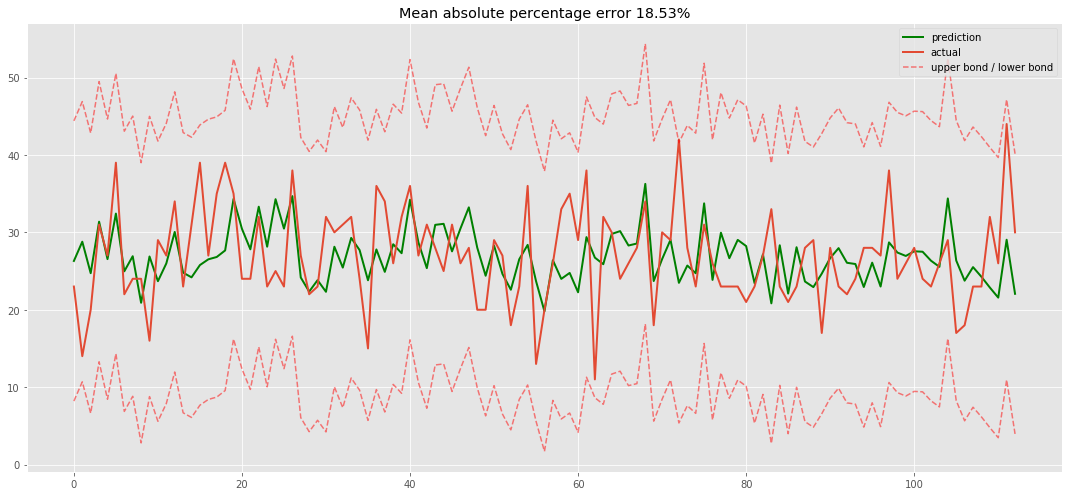

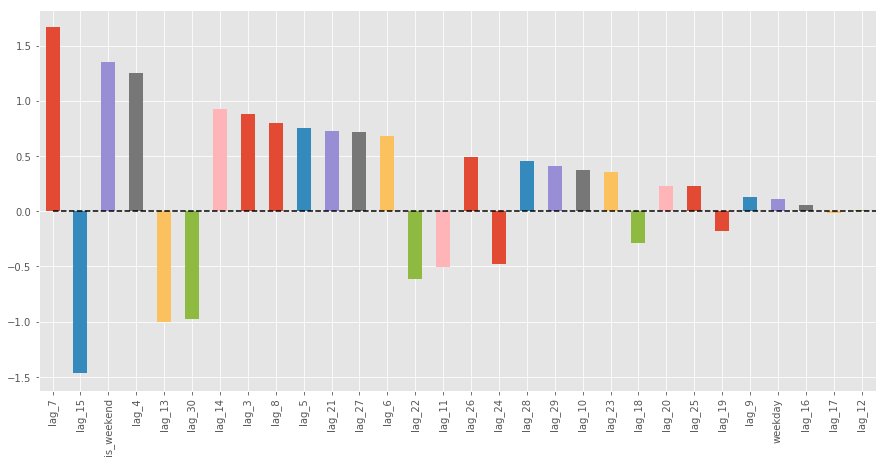

In [88]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [89]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [91]:
average_weekday = code_mean(data, 'weekday', "y")

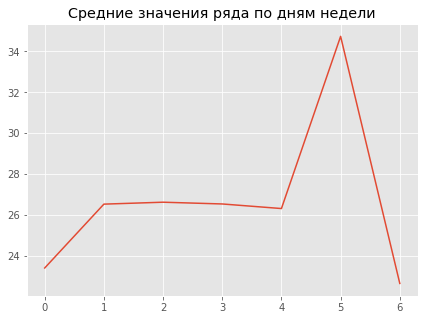

In [92]:
plt.figure(figsize=(7, 5))
plt.title("Средние значения ряда по дням недели")
pd.DataFrame.from_dict(average_weekday, orient='index')[0].plot()
plt.grid(True);

In [93]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = pd.to_datetime(data.index)
    #data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        #data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop([ "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

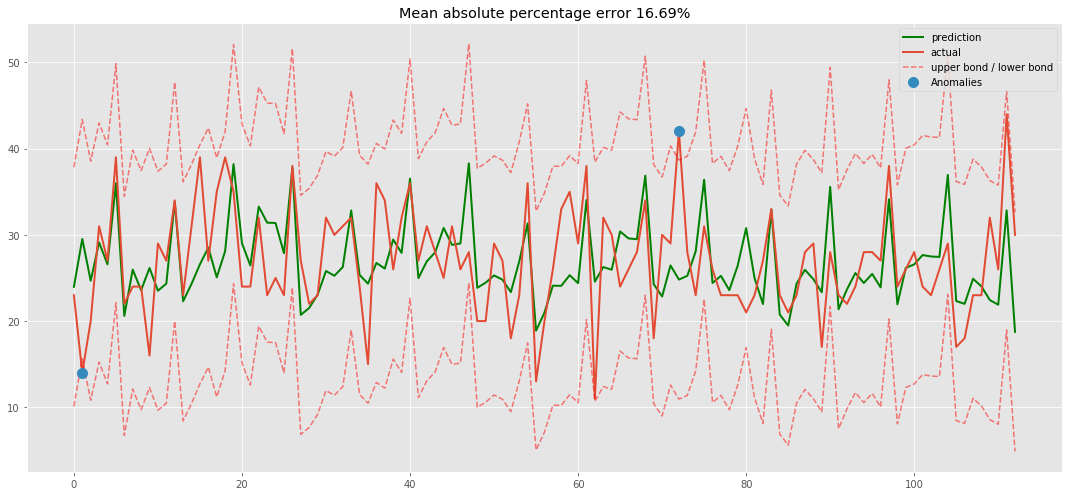

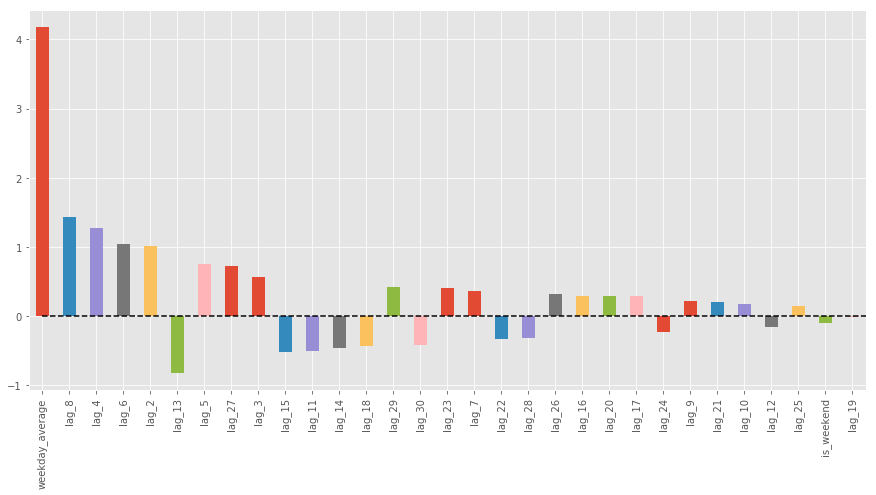

In [98]:
X_train, X_test, y_train, y_test =\
prepareData(total_df.visits, lag_start=2, lag_end=31, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [99]:
X_train, X_test, y_train, y_test =\
prepareData(total_df.visits, lag_start=2, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

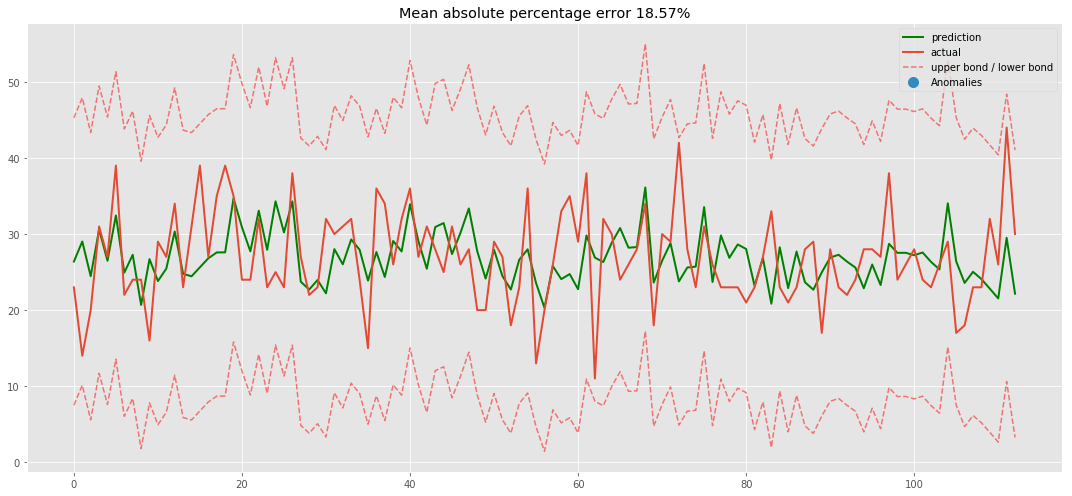

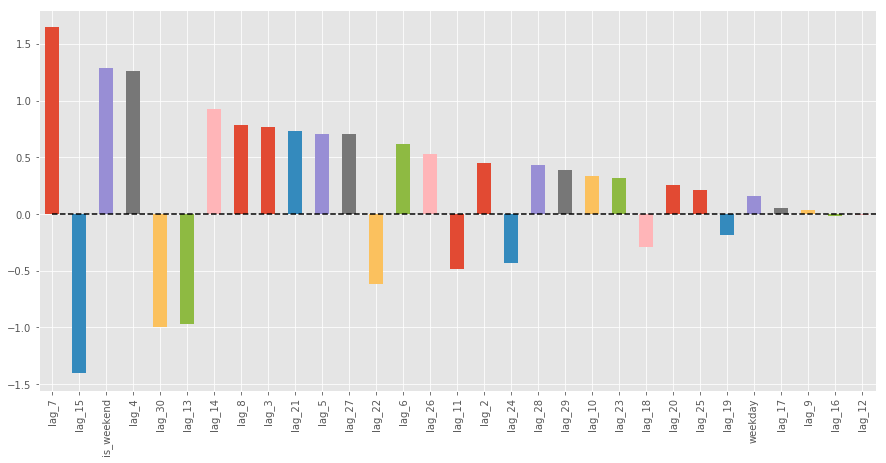

In [100]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

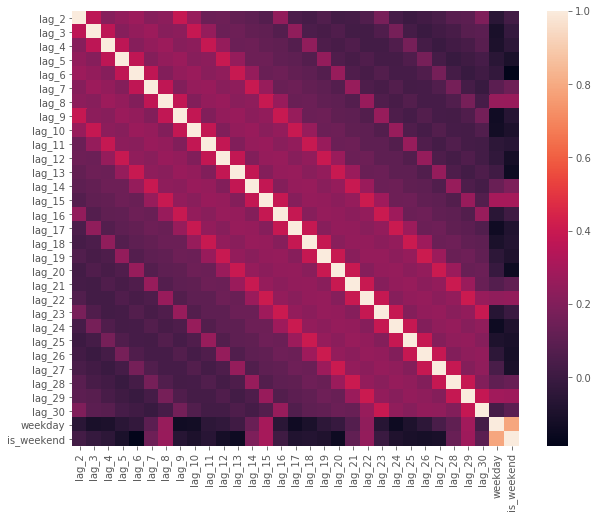

In [101]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [102]:
from sklearn.linear_model import LassoCV, RidgeCV

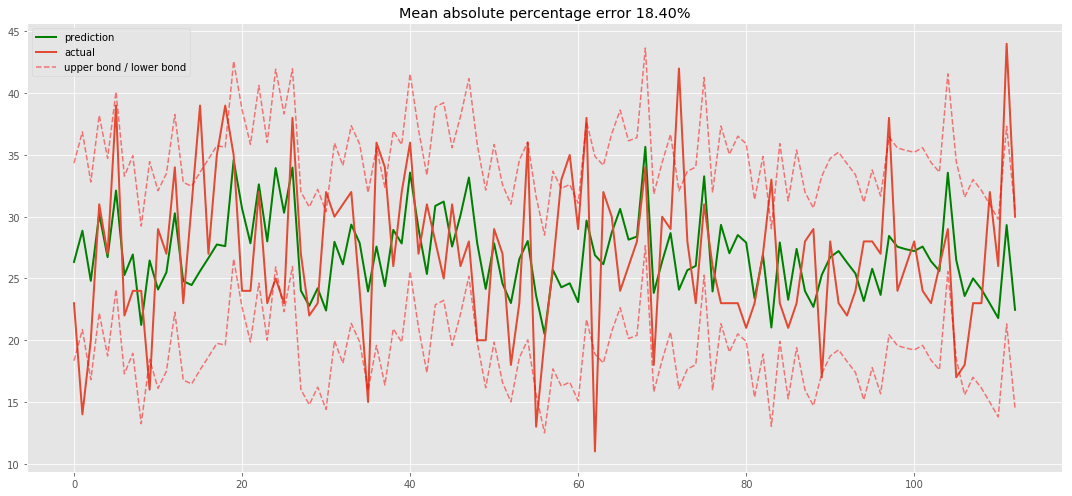

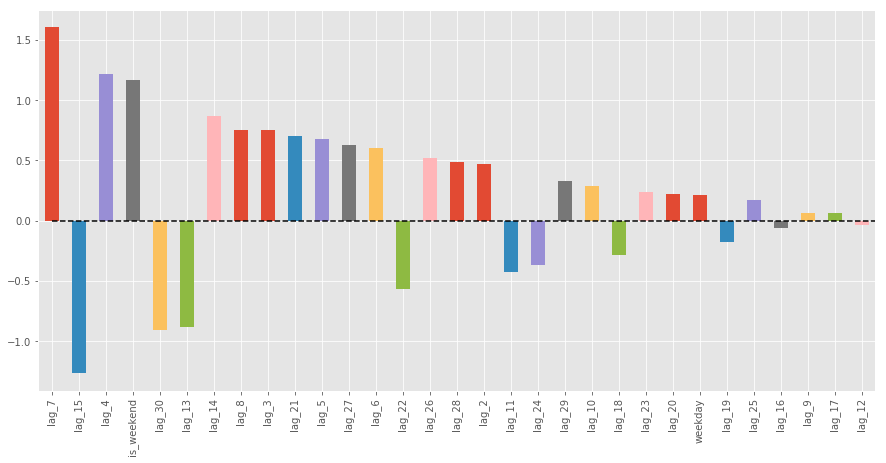

In [103]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(ridge)

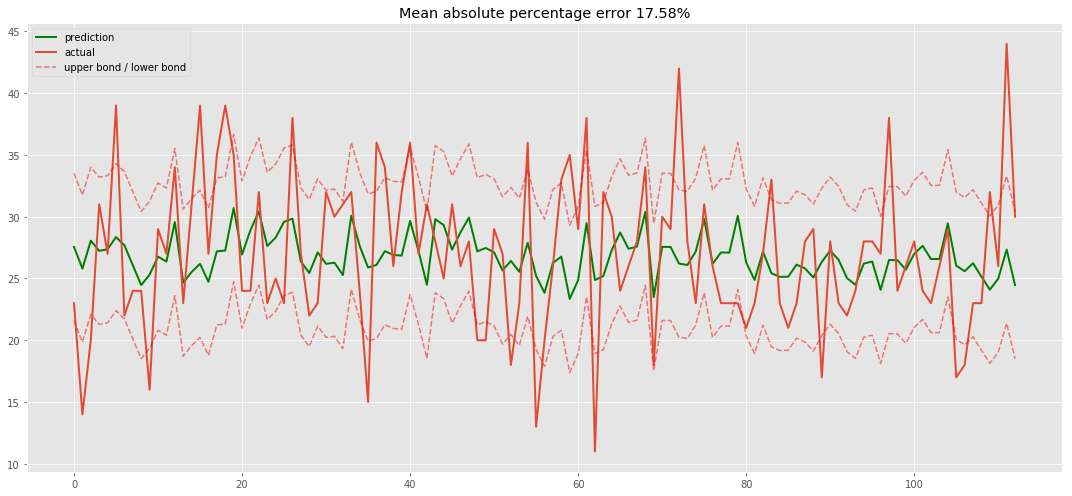

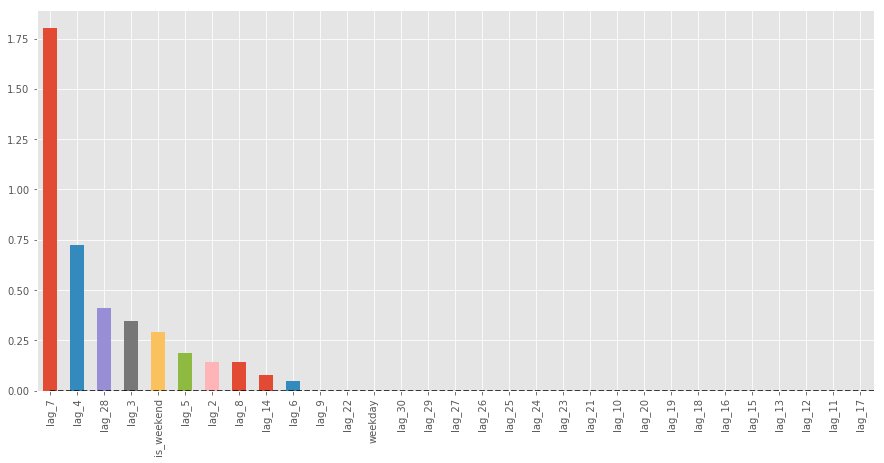

In [104]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(lasso)

In [105]:
from xgboost import XGBRegressor 

In [106]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

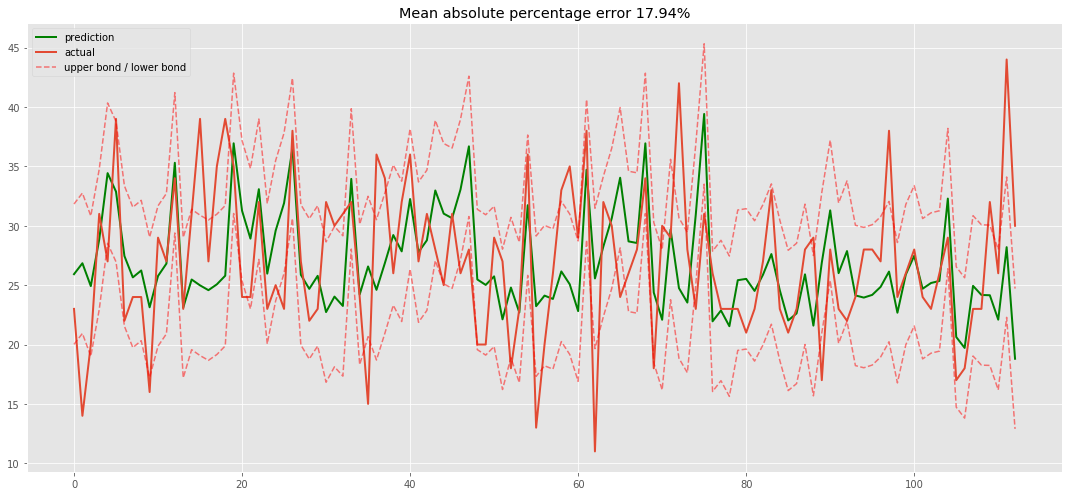

In [107]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)

In [108]:
from fbprophet import Prophet

In [109]:
# задаем число предсказаний будущих значений
predictions = 60

# создаем специфический датасет, с определенными названиями столбцов
df = total_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
400,2018-09-26,23
401,2018-09-27,32
402,2018-09-28,26
403,2018-09-29,44
404,2018-09-30,30


In [110]:
# откладываем часть данных для тестирования
train_df = df[:-predictions]

In [111]:
# обучаем модель, обязательно указывая тип сезонности, который хотим использовать
model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df)

# создаем еще один специфический датафрейм, который нужен для предсказаний
# здесь нужно указать частоту данных (по умолчанию - дни)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
400,2018-08-04 08:00:00
401,2018-08-04 09:00:00
402,2018-08-04 10:00:00
403,2018-08-04 11:00:00
404,2018-08-04 12:00:00


In [112]:
# делаем предсказания 
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
400,2018-08-04 08:00:00,23.112808,20.780880,36.006694,23.112808,23.112808,5.013076,5.013076,5.013076,-0.777995,-0.777995,-0.777995,5.791070,5.791070,5.791070,0.0,0.0,0.0,28.125884
401,2018-08-04 09:00:00,23.114069,18.876349,34.787292,23.114069,23.114069,3.739899,3.739899,3.739899,-1.555989,-1.555989,-1.555989,5.295888,5.295888,5.295888,0.0,0.0,0.0,26.853968
402,2018-08-04 10:00:00,23.115331,18.326928,34.789928,23.115331,23.115331,3.417795,3.417795,3.417795,-1.347526,-1.347526,-1.347526,4.765322,4.765322,4.765322,0.0,0.0,0.0,26.533126
403,2018-08-04 11:00:00,23.116592,19.135125,34.455425,23.116592,23.116592,3.725999,3.725999,3.725999,-0.477700,-0.477700,-0.477700,4.203699,4.203699,4.203699,0.0,0.0,0.0,26.842592
404,2018-08-04 12:00:00,23.117854,18.968428,34.778648,23.117854,23.117854,3.615637,3.615637,3.615637,0.000000,0.000000,0.000000,3.615637,3.615637,3.615637,0.0,0.0,0.0,26.733491


Mean absolute percentage error 25.17%


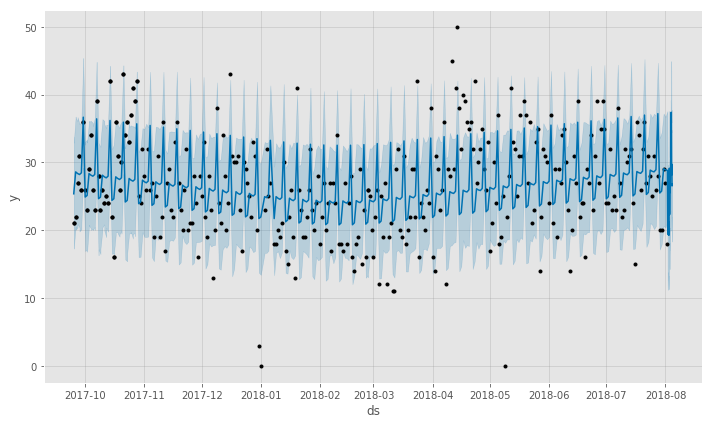

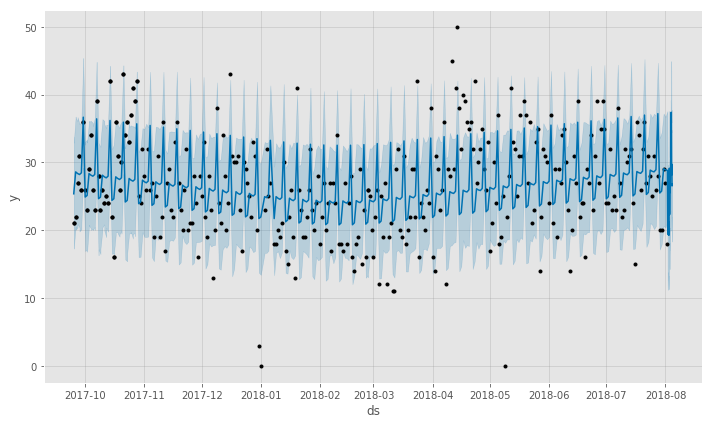

In [113]:
# а теперь рисуем картинки
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
model.plot(forecast)

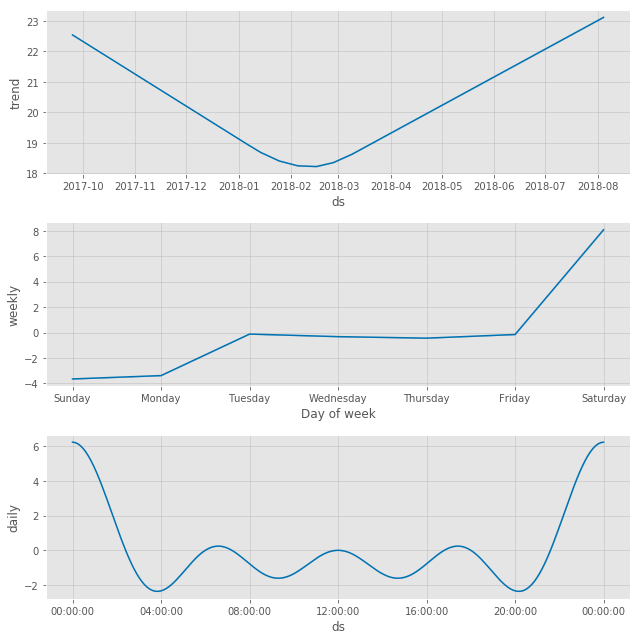

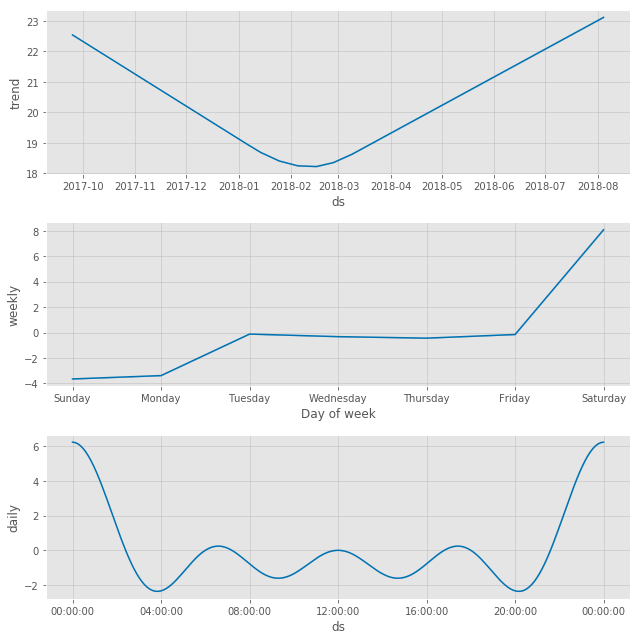

In [114]:
model.plot_components(forecast)

In [115]:
import pandas
import matplotlib.pyplot as plt

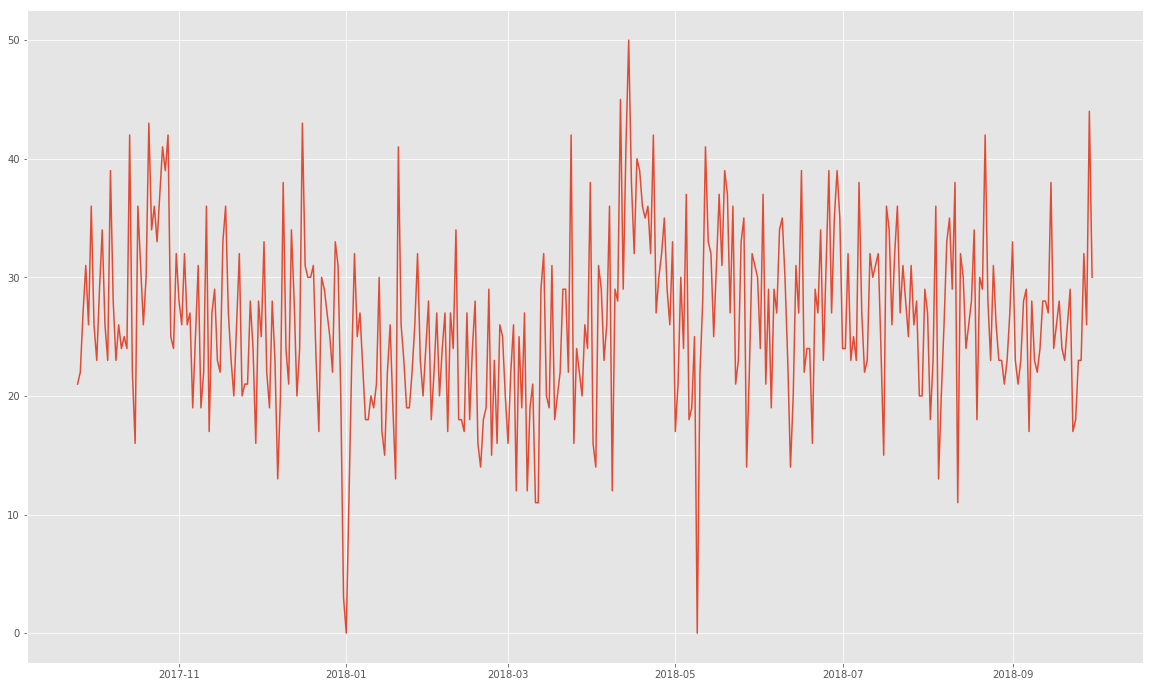

In [117]:
plt.plot(total_df)
plt.show()

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math


In [ ]:
from keras.models import Sequential

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import

In [ ]:
from keras.layers import Dense

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import